<a href="https://colab.research.google.com/github/devansurf/CoralSight-Binary/blob/main/CoralSight_Binary_f1-79_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CoralSight Binary
Computer vision model to differentiate between bleached and non-bleached corals

In [1]:
 !pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 13.9 MB/s eta 0:00:00


In [2]:
#Fetch dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Libaries
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import optuna #tuner
import re
import random
import seaborn as sns
from collections import Counter
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.nn import Module, Conv2d, ConvTranspose2d, Dropout, BatchNorm2d
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, GaussianBlur
from torch.utils.data import random_split


from PIL import Image

from collections import Counter
from tqdm import tqdm
from IPython.display import display, Math, Latex
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split

In [4]:
#directories
bleached_corals_dir = '/content/drive/MyDrive/MachineLearning/coral-dataset/bleached_corals'
healthy_corals_dir = '/content/drive/MyDrive/MachineLearning/coral-dataset/healthy_corals'

In [5]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [6]:
def to_numpy(x):

    return x.detach().cpu().numpy()

In [7]:
#Configuration
class Config:
    learning_rate = 0.00005
    num_epochs = 30
    batch_size = 16
    dropout = 0.5962976867015197
    #dropout': 0.5962976867015197, 'img_dimension': 152
    img_dimensions = (152, 152)
    target_count = 600

    training_proportion = 0.6
    validation_proportion = 0.3

    display_plots = True
    allow_tuner = False

In [8]:
class CoralDataset(Dataset):
    def __init__(self, images, labels, transform=None):

        assert len(images) == len(labels), "Length mismatch between bleached images and labels"
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        label = self.labels[index]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
class CoralCNN(nn.Module):
    def __init__(self, dropout=0.5, img_dimensions=(128,128)):
        super(CoralCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        def conv_output_size(size, kernel_size=3, stride=1, padding=1):
            return (size - kernel_size + 2 * padding) // stride + 1

        size = conv_output_size(img_dimensions[0]) # After first conv layer
        size = size // 2 # After first pooling
        size = conv_output_size(size) # After second conv
        size = size // 2 # After second pooling
        size = conv_output_size(size) # After third conv
        size = size // 2 # After third pooling
        self.final_size = size * size * 128 # Adjusted for 128 filters in the last conv layer


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(self.final_size, 512)
        self.fc2 = nn.Linear(512, 1)
        self.dropout = nn.Dropout(dropout)



    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, self.final_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

In [10]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [11]:
def train_model(learning_rate, epochs, dropout, img_dimensions, train_loader, valid_loader):

    torch.manual_seed(69) # set seed

    model = CoralCNN(dropout=dropout, img_dimensions=img_dimensions)
    print(model) # print model architecture

    if torch.cuda.is_available():
        model = model.to('cuda')  # Move your model to GPU

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

    acc_hist_train = []
    acc_hist_val = []

    train_losses = []
    val_losses = []

    #when trending towards worse validation, stop
    early_stopper = EarlyStopper(patience=10, min_delta=0.1)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            if torch.cuda.is_available():

                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels.float())

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            predicted = torch.round(outputs.data.squeeze())  # Round to 0 or 1

            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        acc_hist_train.append(train_accuracy)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels.float())

                valid_loss += loss.item() * images.size(0)

                predicted = torch.round(outputs.data.squeeze())
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()


        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = correct_val / total_val

        if early_stopper.early_stop(valid_loss):
            print(f'Early Stop -> Epoch = {epoch}')
            break

        if (epoch > 1 and valid_loss < np.min(val_losses)) or epoch == 1:
            torch.save(model.state_dict(), 'checkpoint_loss.pt')
            print("Validation loss checkpoint saved!")

        if (epoch > 1 and valid_accuracy > np.max(acc_hist_val)) or epoch == 1:
            torch.save(model.state_dict(), 'checkpoint_acc.pt')
            print("Validation acc checkpoint saved!")


        acc_hist_val.append(valid_accuracy)
        val_losses.append(valid_loss)

        print("valid loss is: ", valid_loss)
        print("minimum of the losses is: ", np.min(val_losses))

        print(f"Epoch: {epoch}")
        print(f"Train Acc: {train_accuracy:.3f}")
        print(f"Val Acc: {valid_accuracy:.3f}")
        print(f"Train Loss: {train_loss:.3f}")
        print(f"Val Loss: {valid_loss:.3f}")
        print("---------------------------------------------")



    model.eval()
    return model, acc_hist_train, acc_hist_val, train_losses, val_losses

In [12]:
#Function to oversample a subset
def oversample(image_paths, labels, target_count=Config.target_count):
    oversampled_image_paths = []
    oversampled_labels = []

    label_counts = Counter(labels)
    for label in label_counts:
        label_indices = [i for i, lbl in enumerate(labels) if lbl == label]
        oversampled_indices = random.choices(label_indices, k=target_count - label_counts[label])
        oversampled_image_paths.extend([image_paths[i] for i in oversampled_indices])
        oversampled_labels.extend([label] * len(oversampled_indices))

    return image_paths + oversampled_image_paths, labels + oversampled_labels

In [13]:
#Calculate mean std helper:
def calculate_mean_std(dataset):
    dataset_dataloader = DataLoader(
        dataset, batch_size=len(dataset), num_workers=1
    ) # this will allow us to iterate through images in batches
    data = next(iter(dataset_dataloader))
    return data[0].mean(), data[0].std()
    # mean = 0.
    # std = 0.
    # nb_samples = 0.
    # for data, _ in tqdm(dataset_dataloader):
    #     batch_samples = data.size(0)
    #     data = data.view(batch_samples, data.size(1), -1)
    #     mean += data.mean(2).sum(0)
    #     std += data.std(2).sum(0)
    #     nb_samples += batch_samples

    # mean /= nb_samples
    # std /= nb_samples

    # print(f'Mean: {mean}')
    # print(f'Std: {std}')
    # return mean, std

**Create the Datasets with the specified transform (augmentation)** 😀

In [14]:
bleached_images = [os.path.join(bleached_corals_dir, img) for img in os.listdir(bleached_corals_dir)]
healthy_images = [os.path.join(healthy_corals_dir, img) for img in os.listdir(healthy_corals_dir)]

all_images = bleached_images + healthy_images
all_labels = [0] * len(bleached_images) + [1] * len(healthy_images)

dataset = CoralDataset(all_images, all_labels, transforms.Compose([ transforms.Resize(Config.img_dimensions), transforms.ToTensor(),]))
mean, std = calculate_mean_std(dataset=dataset)
#Define transforms (augmentations)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(Config.img_dimensions[0], scale=(0.9, 1.0)),  # Random zoom,
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
])

validation_transform = transforms.Compose([
    transforms.Resize(Config.img_dimensions),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
])



#calculate lengths
total_size = len(dataset)
train_size = int(total_size * Config.training_proportion)
valid_size = int(total_size * Config.validation_proportion)
test_size = total_size - train_size - valid_size

def split_dataset(bleached_corals_dir, healthy_corals_dir, train_size, valid_size, test_size):

    # Combine bleached and healthy images and labels
    bleached_images = [os.path.join(bleached_corals_dir, img) for img in os.listdir(bleached_corals_dir)]
    healthy_images = [os.path.join(healthy_corals_dir, img) for img in os.listdir(healthy_corals_dir)]

    all_image_paths = bleached_images + healthy_images
    all_labels = [0] * len(bleached_images) + [1] * len(healthy_images)  # 0 for bleached, 1 for healthy

    # First split to separate out the training data
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, train_size=train_size, random_state=42)

    # Adjust validation_size to account for the reduced dataset size
    validation_size_adjusted = valid_size / (valid_size + test_size)

    # Split the remaining data into validation and test sets
    validation_paths, test_paths, validation_labels, test_labels = train_test_split(
        temp_paths, temp_labels, train_size=validation_size_adjusted, random_state=42)

    return train_paths, train_labels, validation_paths, validation_labels, test_paths, test_labels

#call the split dataset function
train_image_paths, train_labels, valid_image_paths, valid_labels, test_image_paths, test_labels = split_dataset(bleached_corals_dir, healthy_corals_dir, train_size, valid_size, test_size)

#Oversample the training subset
oversampled_train_image_paths, oversampled_train_labels = oversample(train_image_paths, train_labels)

#data was split this way in order to apply different transforms across subsets
train_dataset = CoralDataset(oversampled_train_image_paths, oversampled_train_labels, transform=train_transform)
valid_dataset = CoralDataset(valid_image_paths, valid_labels, transform=validation_transform)
test_dataset =  CoralDataset(test_image_paths, test_labels, transform=validation_transform)

#creating data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)


**Display some images and labels for reference**

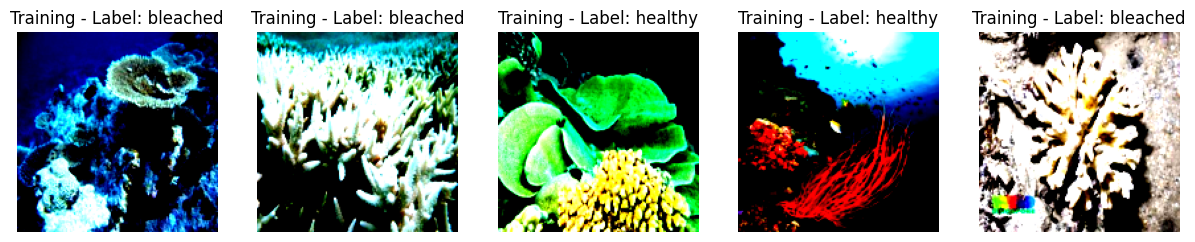

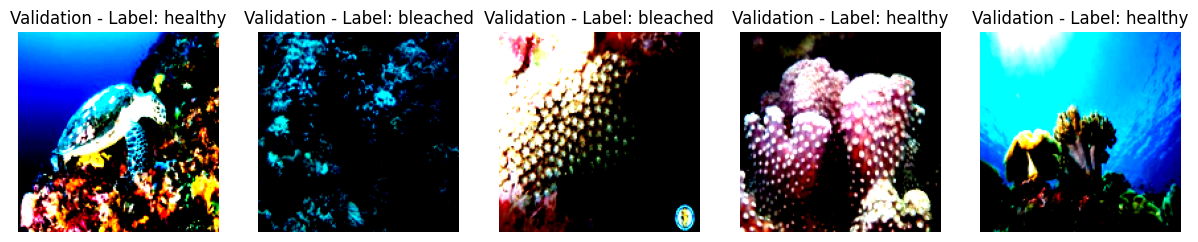

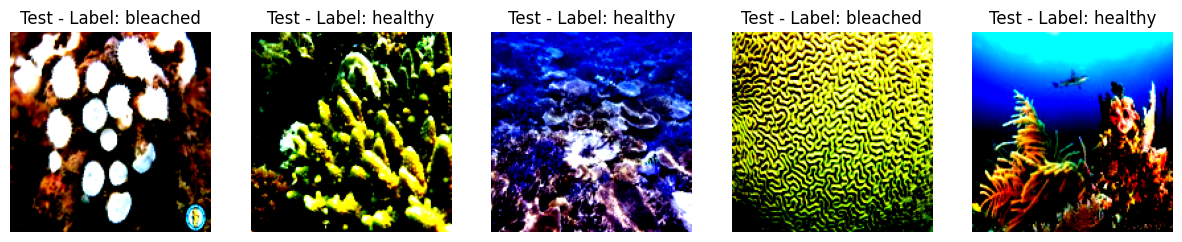

In [15]:
def show_random_images(subset, subset_name, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Randomly select an index
        idx = random.randint(0, len(subset) - 1)

        # Get the image and label
        image, label= subset[idx]
        label = 'bleached' if label == 0 else 'healthy'
        # Convert the tensor image to a NumPy array for visualization
        image_np = image.permute(1, 2, 0).numpy()

        # Subplot for each image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_np)
        plt.title(f'{subset_name} - Label: {label}')
        plt.axis('off')

    plt.show()

if Config.display_plots:
    show_random_images(train_dataset, 'Training', num_images=5)
    show_random_images(valid_dataset, 'Validation', num_images=5)
    show_random_images(test_dataset, 'Test', num_images=5)

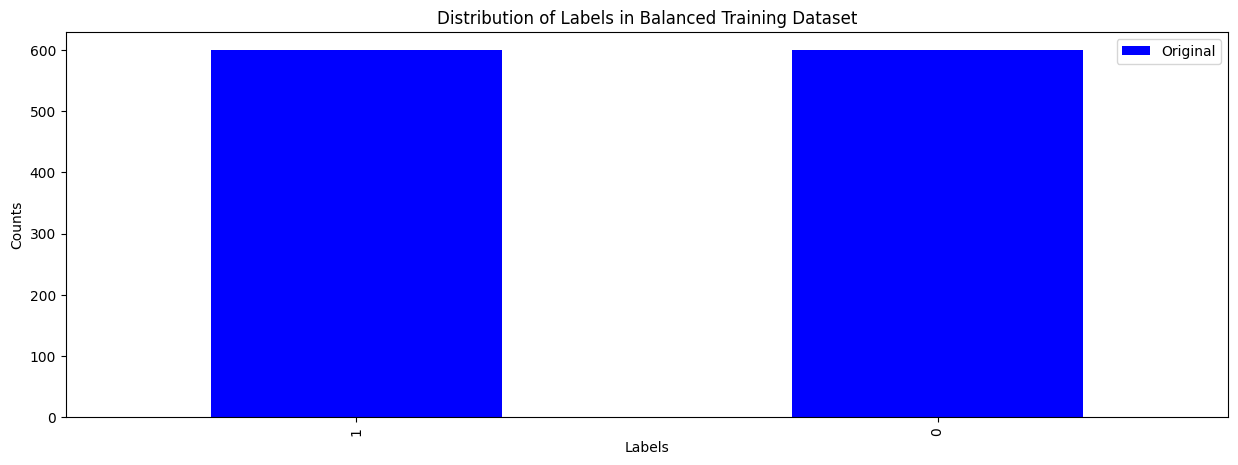

In [16]:

if Config.display_plots:
    counts = {}
    for _, label in train_dataset:
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1

    counts_series = pd.Series(counts)

    # Plot the label counts
    plt.figure(figsize=(15, 5))
    # Plot original counts
    counts_series.plot(kind='bar', color='blue', label='Original')

    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title('Distribution of Labels in Balanced Training Dataset')
    plt.legend()
    plt.show()

**TUNER TIME**

In [17]:
#tuner function
def tuner(trial):
    # Define the hyperparameters to be tuned
    dropout = trial.suggest_float('dropout', 0, 0.6)
    img_dimension = trial.suggest_int('img_dimension', 128, 256, step= 8) #128 to 256 with steps of 8


    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(img_dimension, scale=(0.9, 1.0)),  # Random zoom,
        transforms.ToTensor(),

    ])

    validation_transform = transforms.Compose([
        transforms.Resize((img_dimension, img_dimension)),
        transforms.ToTensor(),
    ])

    #Custom dataset for tuner
    train_dataset = CoralDataset(oversampled_train_image_paths, oversampled_train_labels, transform=train_transform)
    valid_dataset = CoralDataset(valid_image_paths, valid_labels, transform=validation_transform)
    test_dataset =  CoralDataset(test_image_paths, test_labels, transform=validation_transform)

    #creating data loaders for each set
    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)

    model, acc_hist_train, acc_hist_val, train_losses, val_losses = train_model(Config.learning_rate, Config.num_epochs, dropout, (img_dimension,img_dimension), train_loader, valid_loader)
    return max(acc_hist_val)

if Config.allow_tuner:
    study = optuna.create_study(direction='maximize')
    study.optimize(tuner, n_trials=1000)

    best_params = study.best_params
    print("Best hyperparameters: ", best_params)

**Train the model !!!!**

In [18]:
model, acc_hist_train, acc_hist_val, train_losses, val_losses = train_model(Config.learning_rate, Config.num_epochs, Config.dropout, Config.img_dimensions, train_loader, valid_loader)

CoralCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=46208, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5962976867015197, inplace=False)
)


100%|██████████| 38/38 [00:08<00:00,  4.57it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  0.5136776151864425
minimum of the losses is:  0.5136776151864425
Epoch: 1
Train Acc: 0.652
Val Acc: 0.750
Train Loss: 0.698
Val Loss: 0.514
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.07it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  0.5024507719537487
minimum of the losses is:  0.5024507719537487
Epoch: 2
Train Acc: 0.762
Val Acc: 0.779
Train Loss: 0.493
Val Loss: 0.502
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.82it/s]


Validation loss checkpoint saved!
valid loss is:  0.4915500766989114
minimum of the losses is:  0.4915500766989114
Epoch: 3
Train Acc: 0.770
Val Acc: 0.779
Train Loss: 0.473
Val Loss: 0.492
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


valid loss is:  0.5031772307727648
minimum of the losses is:  0.4915500766989114
Epoch: 4
Train Acc: 0.794
Val Acc: 0.779
Train Loss: 0.442
Val Loss: 0.503
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  4.85it/s]


valid loss is:  0.5383151959681857
minimum of the losses is:  0.4915500766989114
Epoch: 5
Train Acc: 0.812
Val Acc: 0.761
Train Loss: 0.402
Val Loss: 0.538
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


valid loss is:  0.5271148249722909
minimum of the losses is:  0.4915500766989114
Epoch: 6
Train Acc: 0.842
Val Acc: 0.779
Train Loss: 0.364
Val Loss: 0.527
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.67it/s]


Validation acc checkpoint saved!
valid loss is:  0.5135088018749071
minimum of the losses is:  0.4915500766989114
Epoch: 7
Train Acc: 0.847
Val Acc: 0.793
Train Loss: 0.350
Val Loss: 0.514
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.55it/s]


valid loss is:  0.5468878884246384
minimum of the losses is:  0.4915500766989114
Epoch: 8
Train Acc: 0.855
Val Acc: 0.768
Train Loss: 0.332
Val Loss: 0.547
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.58it/s]


valid loss is:  0.5559184620345848
minimum of the losses is:  0.4915500766989114
Epoch: 9
Train Acc: 0.851
Val Acc: 0.790
Train Loss: 0.338
Val Loss: 0.556
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.68it/s]


valid loss is:  0.5390423138936361
minimum of the losses is:  0.4915500766989114
Epoch: 10
Train Acc: 0.876
Val Acc: 0.790
Train Loss: 0.294
Val Loss: 0.539
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.41it/s]


valid loss is:  0.5387491203736567
minimum of the losses is:  0.4915500766989114
Epoch: 11
Train Acc: 0.899
Val Acc: 0.793
Train Loss: 0.259
Val Loss: 0.539
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.39it/s]


Validation acc checkpoint saved!
valid loss is:  0.5608495698458906
minimum of the losses is:  0.4915500766989114
Epoch: 12
Train Acc: 0.905
Val Acc: 0.801
Train Loss: 0.245
Val Loss: 0.561
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.22it/s]


valid loss is:  0.550259064073148
minimum of the losses is:  0.4915500766989114
Epoch: 13
Train Acc: 0.907
Val Acc: 0.797
Train Loss: 0.234
Val Loss: 0.550
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.80it/s]


Validation acc checkpoint saved!
valid loss is:  0.5667136553404988
minimum of the losses is:  0.4915500766989114
Epoch: 14
Train Acc: 0.920
Val Acc: 0.808
Train Loss: 0.223
Val Loss: 0.567
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.18it/s]


valid loss is:  0.5826374231905177
minimum of the losses is:  0.4915500766989114
Epoch: 15
Train Acc: 0.927
Val Acc: 0.793
Train Loss: 0.203
Val Loss: 0.583
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.77it/s]


Validation acc checkpoint saved!
valid loss is:  0.5915575943131378
minimum of the losses is:  0.4915500766989114
Epoch: 16
Train Acc: 0.943
Val Acc: 0.812
Train Loss: 0.185
Val Loss: 0.592
---------------------------------------------


100%|██████████| 38/38 [00:10<00:00,  3.53it/s]


valid loss is:  0.604985981747724
minimum of the losses is:  0.4915500766989114
Epoch: 17
Train Acc: 0.932
Val Acc: 0.757
Train Loss: 0.185
Val Loss: 0.605
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.25it/s]


valid loss is:  0.6725755256155262
minimum of the losses is:  0.4915500766989114
Epoch: 18
Train Acc: 0.961
Val Acc: 0.779
Train Loss: 0.150
Val Loss: 0.673
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.74it/s]


valid loss is:  0.5988903589870619
minimum of the losses is:  0.4915500766989114
Epoch: 19
Train Acc: 0.948
Val Acc: 0.804
Train Loss: 0.156
Val Loss: 0.599
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.12it/s]


valid loss is:  0.605033026225325
minimum of the losses is:  0.4915500766989114
Epoch: 20
Train Acc: 0.947
Val Acc: 0.801
Train Loss: 0.160
Val Loss: 0.605
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.80it/s]


valid loss is:  0.6287014812662981
minimum of the losses is:  0.4915500766989114
Epoch: 21
Train Acc: 0.956
Val Acc: 0.775
Train Loss: 0.136
Val Loss: 0.629
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.30it/s]


valid loss is:  0.6297596071077429
minimum of the losses is:  0.4915500766989114
Epoch: 22
Train Acc: 0.950
Val Acc: 0.786
Train Loss: 0.152
Val Loss: 0.630
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.85it/s]


valid loss is:  0.6435817108638044
minimum of the losses is:  0.4915500766989114
Epoch: 23
Train Acc: 0.957
Val Acc: 0.786
Train Loss: 0.129
Val Loss: 0.644
---------------------------------------------


100%|██████████| 38/38 [00:07<00:00,  5.24it/s]


valid loss is:  0.6582943062851394
minimum of the losses is:  0.4915500766989114
Epoch: 24
Train Acc: 0.963
Val Acc: 0.779
Train Loss: 0.114
Val Loss: 0.658
---------------------------------------------


100%|██████████| 38/38 [00:06<00:00,  5.89it/s]


Early Stop -> Epoch = 25


In [25]:
#Load loss checkpoint if requested
load_loss_checkpoint = True
if load_loss_checkpoint:
    model = CoralCNN(dropout=Config.dropout, img_dimensions=Config.img_dimensions)
    model.load_state_dict(torch.load('checkpoint_loss.pt'))
    if torch.cuda.is_available():
        model = model.to('cuda')  # Move your model to GPU

In [29]:
load_acc_checkpoint = True
if load_acc_checkpoint:
    model = CoralCNN(dropout=Config.dropout, img_dimensions=Config.img_dimensions)
    model.load_state_dict(torch.load('checkpoint_acc.pt'))
    if torch.cuda.is_available():
        model = model.to('cuda')  # Move your model to GPU

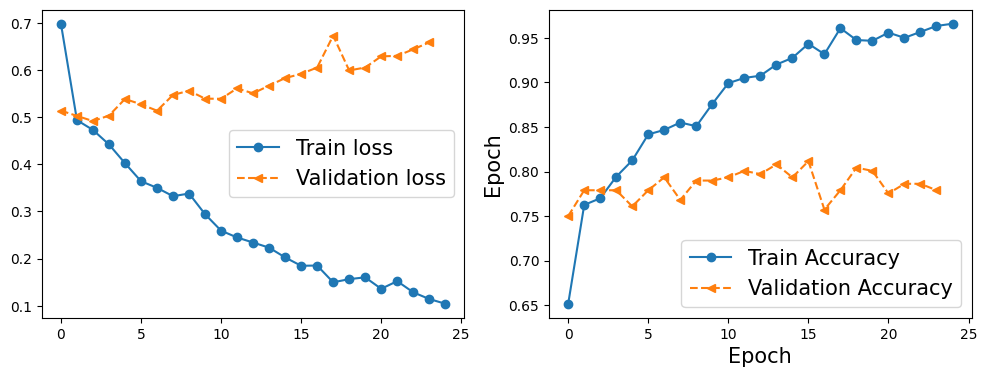

In [30]:
#Plot graphs

loss_axis = list(range(len(train_losses)))
val_axis = list(range(len(val_losses)))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)

ax.plot(loss_axis, train_losses, '-o', label = 'Train loss')
ax.plot(val_axis , val_losses, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(loss_axis, acc_hist_train, '-o', label='Train Accuracy')
ax.plot(val_axis, acc_hist_val, '--<', label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Epoch', size=15)
plt.show()

In [31]:
#Tune threshold on the validation set, use this threshold on test
def threshold_tuner(model, loader):
    best_threshold = 0.5
    max_accuracy = 0

    model.eval()
    with torch.no_grad():
        # Loop through 0.4-0.7 steps of 0.05
        float_range = np.arange(0.4, 0.8, 0.05)
        for i in float_range:
            total_correct = 0
            total_samples = 0
            for x, y in loader:
                if torch.cuda.is_available():
                    x, y = x.cuda(), y.cuda()

                pred = model(x)  # predict
                predictions = (pred.squeeze() >= i).int()
                total_correct += (predictions == y).sum().item()
                total_samples += y.size(0)

            accuracy = total_correct / total_samples
            if accuracy > max_accuracy:
                max_accuracy = accuracy
                best_threshold = i

    return best_threshold

prediction_threshold = threshold_tuner(model, valid_loader)
print("Threshold set to: ", prediction_threshold)

Threshold set to:  0.45


In [32]:
#Final results
total_correct = 0
total_samples = 0
actual_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        pred = model(x)  # predict, this should output the probability of being class '1' (e.g., 'healthy')
        #add tuner to this
        predictions = (pred.squeeze() >= prediction_threshold).int() # Threshold at 0.5; if pred >= 0.5, predictions = 1
        total_correct += (predictions == y).sum().item()
        total_samples += y.size(0)

        actual_labels.extend(to_numpy(y))
        predicted_labels.extend(to_numpy(predictions))

accuracy_test = total_correct / total_samples

print(f'test accuracy: {accuracy_test}')
print("NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.")
F1_score = f1_score(actual_labels, predicted_labels, average='macro')
print(f'F1_score: {F1_score}')

test accuracy: 0.7978723404255319
NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.
F1_score: 0.7960022844089092


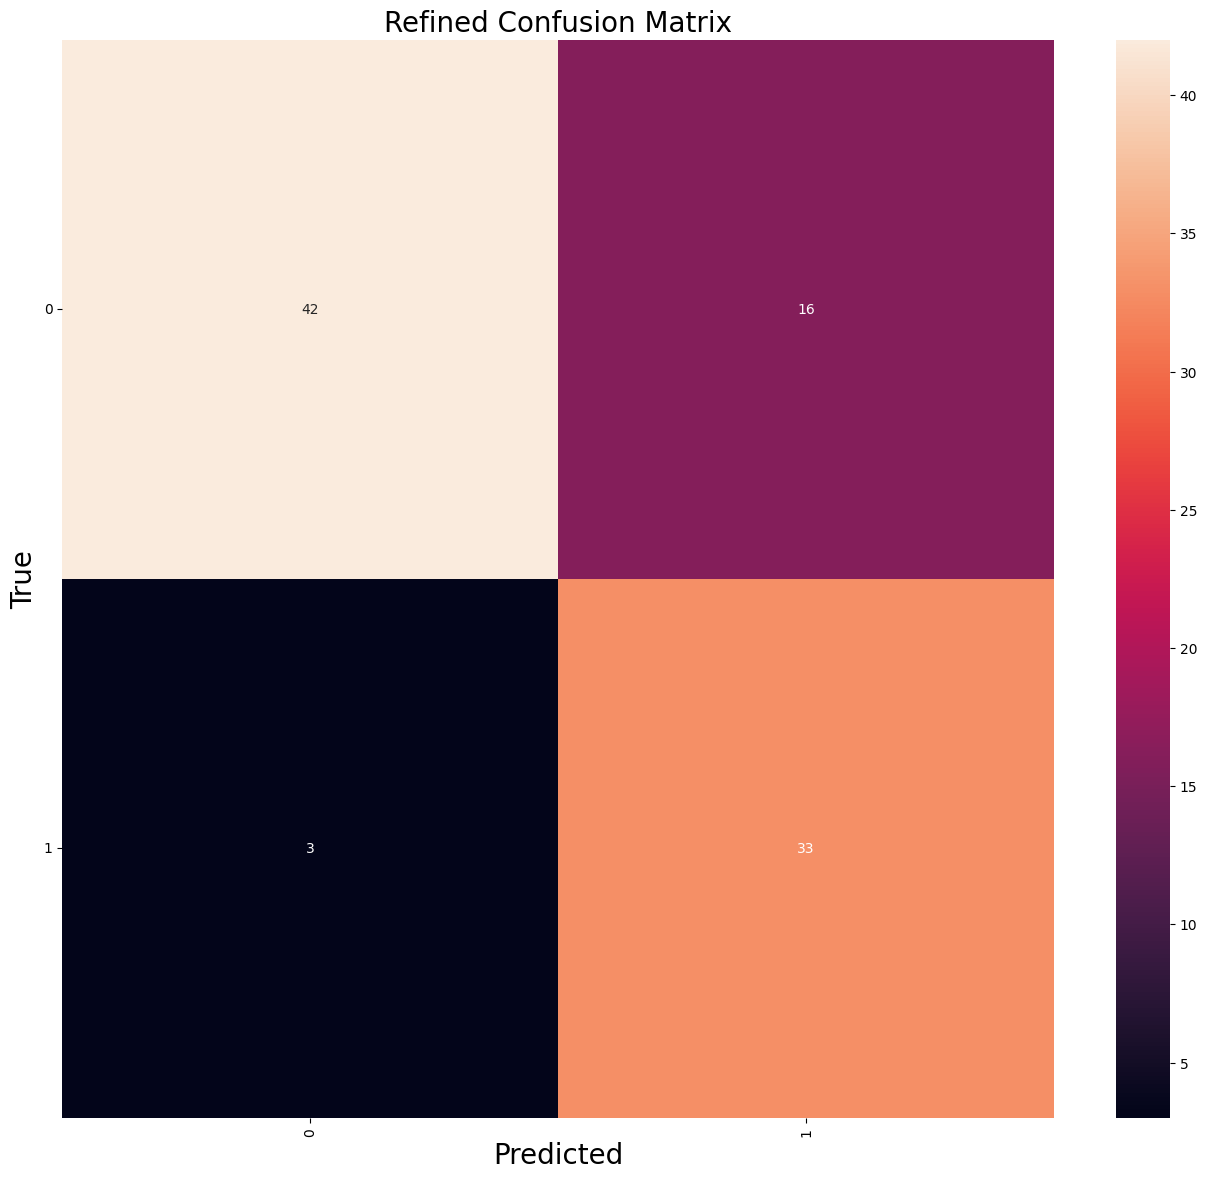

f1_score: 0.7960022844089092


In [33]:
#Confusion matrix:
cm = confusion_matrix(actual_labels, predicted_labels)

labels = list(set(dataset.labels))

fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g")
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.tick_bottom()

ax.set_ylabel("True", fontsize=20)
plt.yticks(rotation=0)

plt.title("Refined Confusion Matrix", fontsize=20)

plt.show()

F1_score = f1_score(actual_labels, predicted_labels, average='macro')

print(f'f1_score: {F1_score}')